In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex

In this notebook we first preform a basic exploratory analysis of the data contained in the metadata associated to the papers.
Then we look at changes in participation accross the years,

In [2]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])

In [64]:
metadata.shape

(3264, 14)

In [3]:
metadata.head(2)

,file,subject,iso,uri,type,publisher,title,issued,accessioned,citation,available,abstract,long_name,shortend_names
0,import2016full_61,NaN,en,info:doi/10.22318/icls2016.61,Book chapter,Singapore: International Society of the Learni...,Exposing Piaget’s Scheme: Empirical Evidence f...,2016-07-01,2017-03-21 12:05:42,"Abrahamson, D., Shayan, S., Bakker, A., & van ...",2017-03-21 12:05:42,The combination of two methodological resource...,"Abrahamson, Dor",Abrahamson D.
1,import2016full_95,NaN,en,info:doi/10.22318/icls2016.95,Book chapter,Singapore: International Society of the Learni...,Secondary Teachers’ Emergent Understanding of ...,2016-07-01,2017-03-21 12:05:42,"Sandoval, W. A., Kawasaki, J., Cournoyer, N., ...",2017-03-21 12:05:42,Abstract: The Next Generation Science Standard...,"Sandoval, William A.",Sandoval W. A.


The following gives a good overview of the type of values we have in the dataset. The first column gives us the number of values. We can discover NaN values present in the dataset. We see that we ave Nan values in the subject and the abstract column.
We can also see the number of unique values in the second column. We see that long name and shortend name have different amounts of unique values. This means we should use the long name instead. 

In [70]:
#metadata[metadata.abstract.isna()].file.to_csv('NO_abstract_files.csv')
metadata[metadata.abstract.isna()].file.head()

61     import2016full_39
418       import2018_401
431       import2018_463
459       import2018_453
475       import2018_517
Name: file, dtype: object

In [71]:
metadata.describe().loc[['count', 'unique']]

,file,subject,iso,uri,type,publisher,title,issued,accessioned,citation,available,abstract,long_name,shortend_names
count,3264,2387,3264,3264,3264,3264,3264,3264,3264,3264,3264,3216,3264,3264
unique,874,592,1,817,1,3,817,4,90,817,90,789,1971,1899


**Looking more into the naming issue**


We construct an index corresponding to each unique name, for both long and short form. Then, we merge long and short. Where both don't overlap, there is some issue with the naming.

Inspeciting the dataframe one finds that there are two cases: 
- small changes in the string make two identical names non identical.
- the citation order is out of order, and this the short form (based on the citation) was assigned incorrectly.
- the short form name is not unique

In [232]:
unique_long = metadata.long_name.drop_duplicates()
unique_short = metadata.shortend_names.drop_duplicates()
names = metadata[['long_name', 'shortend_names']].drop_duplicates()

index_long = unique_long.reset_index()
index_short = unique_short.reset_index()
names = pd.merge(index_long,names, on='long_name')

differences = pd.merge(index_short, names, on='shortend_names')
differences[differences.index_x != differences.index_y]

,index_x,shortend_names,index_y,long_name
22,21,Flood V. J.,499,"Flood, Virginia J"
53,53,Litts B. K.,1389,"Litts, Breanne K"
56,55,Tan E.,63,"Tan, Edna"
72,72,Vitale J.,852,"Vitale, Jonathan"
76,75,Chen J.,1279,"Chen, Jason"
80,78,Margulieux L. E.,1173,"Margulieux, Lauren E"
84,82,Azevedo F. S.,181,"Azevedo, Flavio S."
119,120,Hong H.,1614,"Hong, Helen"
129,133,Wang Q.,1456,"Wang, Qiuchen"
130,133,Wang Q.,1582,"Wang, Qi"


In [240]:
differences[differences.shortend_names == 'Flood V. J.']

,index_x,shortend_names,index_y,long_name
17,21,Flood V. J.,21,"Flood, Virginia J"


We can fix the first problem by transforming the long form of the string. Now only issue 2 and 3 remain:

In [245]:
import unicodedata

In [246]:
unique_long = metadata.long_name.map(lambda x: regex.sub('\.', '',x)).drop_duplicates()
unique_long = unique_long.map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('ascii'))

unique_short = metadata.shortend_names.drop_duplicates()
names = metadata[['long_name', 'shortend_names']].drop_duplicates()

index_long = unique_long.reset_index()
index_short = unique_short.reset_index()
names = pd.merge(index_long,names, on='long_name')

differences = pd.merge(index_short, names, on='shortend_names')
differences[differences.index_x != differences.index_y]

,index_x,shortend_names,index_y,long_name
40,55,Tan E.,63,"Tan, Edna"
55,72,Vitale J.,852,"Vitale, Jonathan"
57,75,Chen J.,1279,"Chen, Jason"
73,99,Dascalu M.,1006,"Dascalu, Mihai"
88,120,Hong H.,1614,"Hong, Helen"
98,133,Wang Q.,1456,"Wang, Qiuchen"
99,133,Wang Q.,1582,"Wang, Qi"
105,143,Matuk C.,454,"Hovey, Christopher M"
109,148,Zhang J.,1556,"Zhang, Jiayuan"
157,215,Greenhow C.,2380,"Greenhow, Christine"


In [244]:
differences[differences.shortend_names =='Tan E.'], differences[differences.shortend_names =='Roy D.']

(    index_x shortend_names  index_y    long_name
 39       55         Tan E.       55  Tan, Esther
 40       55         Tan E.       63    Tan, Edna,
       index_x shortend_names  index_y long_name
 1311     2382         Roy D.     2382  Roy, Dan
 1312     2382         Roy D.     3039  Roy, Deb)

Use the cleaned long name string:

In [248]:
metadata.loc['long_name'] = metadata.long_name.map(lambda x: regex.sub('\.', '',x)).map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('ascii'))

# Looking at the authors:

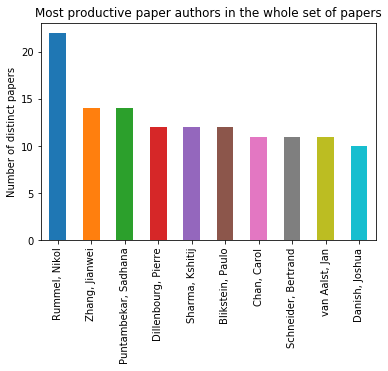

In [249]:
plt.title('Most productive paper authors in the whole set of papers')
plt.ylabel('Number of distinct papers')
metadata.long_name.value_counts().head(10).plot(kind = 'bar')
plt.show()

# Looking at the number of papers: 

We see that more papers get published in ICLS than in CLCS.

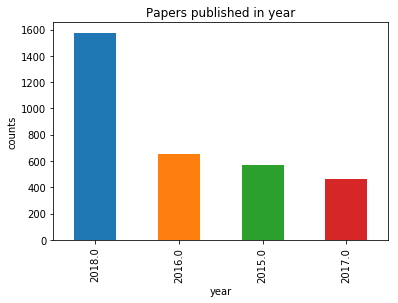

In [250]:
plt.title('Papers published in year')
plt.xlabel('year')
plt.ylabel('counts')
metadata.issued.map(lambda x: x.year).value_counts().plot(kind='bar')
plt.show()

In [275]:
pd.DataFrame(metadata.groupby(['issued']).long_name.value_counts(), 'col').reset_index()

ValueError: cannot insert long_name, already exists

In [251]:
#metadata.groupby('issued').shortend_names.value_counts().plot(kind = 'bar')

People who submitted every year of the year:

In [252]:
C_2015 = set(metadata[metadata.issued.map(lambda x: x.year) == 2015].long_name.tolist())
C_2016 = set(metadata[metadata.issued.map(lambda x: x.year) == 2016].long_name.tolist())
C_2017 = set(metadata[metadata.issued.map(lambda x: x.year) == 2017].long_name.tolist())
C_2018 = set(metadata[metadata.issued.map(lambda x: x.year) == 2018].long_name.tolist())

In [253]:
regulars = C_2015.intersection(C_2017).intersection(C_2016.intersection(C_2018))
print('Number of people who submit every year: ', len(regulars))
regulars

Number of people who submit every year:  25


{'Acosta, Alisa',
 'Anderson, Emma',
 'Andrade, Alejandro',
 'Borge, Marcela',
 'Chen, Bodong',
 'Dillenbourg, Pierre',
 'Gnesdilow, Dana',
 'Hartmann, Christian',
 'Kollar, Ingo',
 'Ma, Leanne',
 'Matuk, Camillia',
 'Moher, Tom',
 'Nistor, Nicolae',
 'Oshima, Jun',
 'Oshima, Ritsuko',
 'Puntambekar, Sadhana',
 'Rummel, Nikol',
 'Scardamalia, Marlene',
 'Schneider, Bertrand',
 'Shaffer, David Williamson',
 'Sharma, Kshitij',
 'Thompson, Kate',
 'Weinberger, Armin',
 'Zhang, Jianwei',
 'van Aalst, Jan'}

People who only subitted to 2015 and 2017:

In [254]:
CLCS_only = C_2015.intersection(C_2017).difference(C_2016.intersection(C_2018))
print('Number of CLCS only participants: ', len(CLCS_only))
CLCS_only

Number of CLCS only participants:  46


{'Antle, Alissa Nicole',
 'Blikstein, Paulo',
 'Chan, Carol K.K.',
 'Chen, Mei-Hwa',
 'Chounta, Irene-Angelica',
 'Dascalu, Mihai',
 'Dornfeld, Catherine',
 'Fischer, Frank',
 'Georgen, Chris',
 'Hakkarainen, Kai',
 'Hao, Jiangang',
 'Hecking, Tobias',
 'Hirayama, Ryoya',
 'Hmelo-Silver, Cindy E.',
 'Hoppe, H. Ulrich',
 'Jeong, Heisawn',
 'Jermann, Patrick',
 'Kubota, Yoshihiko',
 'Kyewski, Elias',
 'Kyllonen, Patrick',
 'Linn, Marcia C.',
 'Liu, Lei',
 'Lui, Michelle',
 'Matsuzawa, Yoshiaki',
 'McNamara, Danielle S.',
 'Mercier, Emma',
 'Mochizuki, Toshio',
 'Peppler, Kylie',
 'Prieto, Luis P.',
 'Puhl, Thomas',
 'Quignard, Matthieu',
 'Sasaki, Hiroshi',
 'Slotta, James D.',
 'Stegmann, Karsten',
 'Suzuki, Hideyuki',
 'Tabak, Iris',
 'Tao, Dan',
 'Trausan-Matu, Stefan',
 'Tsovaltzi, Dimitra',
 'Vogel, Freydis',
 'Wakimoto, Takehiro',
 'Warren, Jillian',
 'Wen, Miaomiao',
 'Wichmann, Astrid',
 'Wise, Alyssa Friend',
 'Yoon, Susan A.'}

In [255]:
ICLS_only = (C_2016.intersection(C_2018)).difference(C_2015.intersection(C_2017))
print('Number of ICLS only participants: ', len(ICLS_only))
ICLS_only

Number of ICLS only participants:  129


{'Abrahamson, Dor',
 'Ahn, June',
 'Ainsworth, Shaaron',
 'Aleven, Vincent',
 'Askari, Emilia',
 'Asterhan, Christa',
 'Bakker, Arthur',
 'Bang, Megan',
 'Barton, Angela Calabrese',
 'Basu, Satabdi',
 'Becker, Sandra',
 'Bell, Philip',
 'Ben-Zvi, Dani',
 'Berland, Matthew',
 'Bernstein, Debra',
 'Biswas, Gautam',
 'Bodemer, Daniel',
 'Charles, Elizabeth S.',
 'Chiu, Thomas K.F.',
 'Clarke, Sherice',
 'Clegg, Tamara',
 'Curnow, Joe',
 'Dahn, Maggie',
 'Danish, Joshua',
 'DeLiema, David',
 'Deitrick, Elise',
 'Derry, Sharon',
 'Dugdale, Michael',
 'Dyer, Elizabeth B.',
 'Enyedy, Noel',
 'Erkens, Melanie',
 'Feng, Mingyu',
 'Forbes, Cory',
 'Gerard, Libby',
 'Gerritsen, David',
 'Gobert, Janice',
 'Gouvea, Julia Svoboda',
 'Gravel, Brian',
 'Grover, Shuchi',
 'Heimbuch, Sven',
 'Hew, Khe Foon',
 'Hickey, Daniel T.',
 'Hilppö, Jaakko',
 'Hinojosa, Leighanna',
 'Hjorth, Arthur',
 'Hod, Yotam',
 'Hong, Helen',
 'Hong, Huang-Yao',
 'Horn, Ilana Seidel',
 'Humburg, Megan',
 'Iikubo, Shinya',
 

## Analyzing the regulars

The metadata associated with the regulars:

In [257]:
metadata[metadata.long_name.isin(regulars)].long_name.value_counts()

Rummel, Nikol                22
Puntambekar, Sadhana         14
Zhang, Jianwei               14
Sharma, Kshitij              12
Dillenbourg, Pierre          12
Schneider, Bertrand          11
van Aalst, Jan               11
Oshima, Jun                  10
Kollar, Ingo                 10
Moher, Tom                    9
Scardamalia, Marlene          9
Borge, Marcela                8
Chen, Bodong                  8
Anderson, Emma                8
Weinberger, Armin             8
Matuk, Camillia               7
Andrade, Alejandro            7
Thompson, Kate                6
Oshima, Ritsuko               6
Acosta, Alisa                 6
Gnesdilow, Dana               6
Shaffer, David Williamson     6
Hartmann, Christian           5
Ma, Leanne                    5
Nistor, Nicolae               4
Name: long_name, dtype: int64